In [ ]:
from google.colab import drive
import os
from pathlib import Path


drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

dataset_dir = "/content/drive/MyDrive/dataset"
categories = os.listdir(dataset_dir)

print(categories)

['chicken_pox', 'cow_pox', 'healthy', 'HFMD', 'measles', 'monkey_pox']


In [ ]:

IMG_SIZE = (299, 299)
BATCH_SIZE = 32
EPOCHS = 20

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


def load_and_split_data(dataset_dir):
    filepaths, labels = [], []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_dir, category)
        for file in os.listdir(category_path):
            filepaths.append(os.path.join(category_path, file))
            labels.append(label)


    X_train, X_temp, y_train, y_temp = train_test_split(filepaths, labels, test_size=0.3, stratify=labels, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(dataset_dir)


In [ ]:

# Data Preprocessing
def preprocess_image(file_path):

    image = tf.image.decode_jpeg(tf.io.read_file(file_path), channels=3)

    image = tf.image.resize(image, IMG_SIZE)

    image = image / 255.0
    return image

In [ ]:

def create_generator(filepaths, labels, batch_size=BATCH_SIZE):
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(categories))
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:

train_generator = create_generator(X_train, y_train)
val_generator = create_generator(X_val, y_val)
test_generator = create_generator(X_test, y_test)


In [ ]:


base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output = Dense(len(categories), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:


for layer in base_model.layers[-50:]:
    layer.trainable = True


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,854,950 (87.18 MB)

 Trainable params: 22,820,518 (87.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/Final-Version-Models-for-Mpox/multiple-classes/best_inception_model_v2.keras", save_best_only=True, monitor='val_loss')


In [ ]:


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
)



Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 682s 5s/step - accuracy: 0.6694 - loss: 0.9057 - val_accuracy: 0.9335 - val_loss: 0.2463 - learning_rate: 1.0000e-04
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 469ms/step - accuracy: 0.9594 - loss: 0.1357 - val_accuracy: 0.9641 - val_loss: 0.0980 - learning_rate: 1.0000e-04
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 450ms/step - accuracy: 0.9940 - loss: 0.0212 - val_accuracy: 0.9676 - val_loss: 0.1022 - learning_rate: 1.0000e-04
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 452ms/step - accuracy: 0.9968 - loss: 0.0097 - val_accuracy: 0.9641 - val_loss: 0.1177 - learning_rate: 1.0000e-04
Epoch 5/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 446ms/step - accuracy: 0.9954 - loss: 0.0126 - val_accuracy: 0.9703 - val_loss: 0.0996 - learning_rate: 1.0000e-04
Epoch 6/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 460ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9711 - val_loss: 0.0950 - learning_rate: 1.0000e-05
Epoch 7/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 494m

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.9823 - loss: 0.0783
Test Loss: 0.10319497436285019
Test Accuracy: 0.9769093990325928


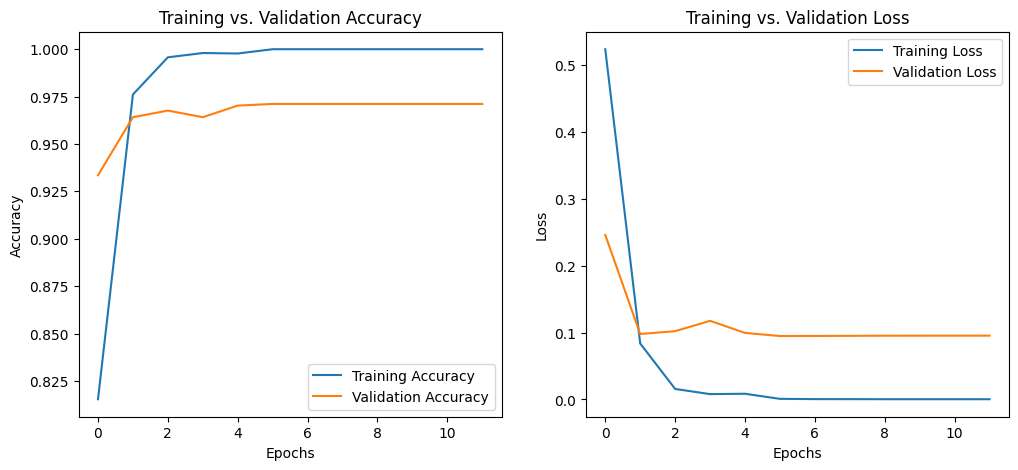

In [ ]:

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 429ms/step
Confusion Matrix:
 [[106   1   3   1   1   1]
 [  0  77   0   1   0   1]
 [  0   0  98   1   0   0]
 [  0   0   0  99   0   0]
 [  1   0   0   0  73   0]
 [  2   0   0   0   0  97]]


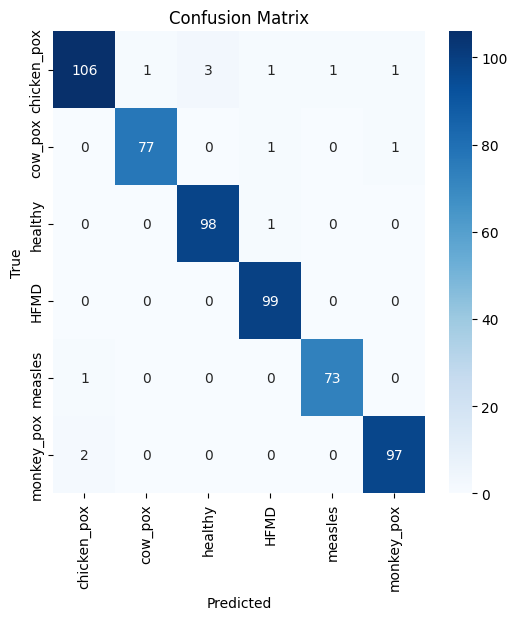

In [ ]:

y_true = []
for features, labels in test_generator:
    y_true.extend(np.argmax(labels.numpy(), axis=-1))

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
# Use categories as labels instead of hardcoded values
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_classes, target_names=categories)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

 chicken_pox       0.97      0.94      0.95       113
     cow_pox       0.99      0.97      0.98        79
     healthy       0.97      0.99      0.98        99
        HFMD       0.97      1.00      0.99        99
     measles       0.99      0.99      0.99        74
  monkey_pox       0.98      0.98      0.98        99

    accuracy                           0.98       563
   macro avg       0.98      0.98      0.98       563
weighted avg       0.98      0.98      0.98       563



In [ ]:
#model.save('/content/drive/MyDrive/best_inception_model.keras')